In [1]:
import numpy as np
import cv2
import subprocess
import torch
from PIL import Image
import os
from scipy.stats import hmean
import sys
import matplotlib.pyplot as plt

In [2]:
# 0. 사용하는 변수

location = "SH" # 불러올 이미지들의 디렉토리 명
road_real_distance = 300 # 도로의 폭은 300cm 로 지정 / 만일 다른 기준객체를 참고하려면 해당 기준객체의 실 cm 값으로 변경

s = 1 # 침수 전 이미지 프레임의 순서 
f = 3 # 침수 후 이미지 프레임의 순서

# image frame 불러오기
img_1 = cv2.imread(f'test/{location}/{s}.jpg', cv2.IMREAD_COLOR) # 물 웅덩이 box 칠, 첫번째 이미지
img_n = cv2.imread(f'test/{location}/{f}.jpg', cv2.IMREAD_COLOR) # n번째 이미지, 해당 코드에서 n=5
cor1 = []
cor2 = []

# # 추가 input: 각 이미지 프레임에 대한 mask 파일
# img_1_mask_path = f'test/{location}/mask_{s}.jpg'
# img_n_mask_path = f'test/{location}/mask_{f}.jpg'

In [3]:
def click_event1(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:
        print(f"Clicked at x={x}, y={y}")
        # cv2.putText(img_1, f'({x},{y})', (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
        cv2.imshow('image', img_1)
        cor1.append(x)
        cor1.append(y)




cv2.imshow('image', img_1)

cv2.setMouseCallback('image', click_event1)
cv2.waitKey(0)
cv2.destroyAllWindows()
print(cor1)

Clicked at x=1375, y=426
[1375, 426]


In [4]:
def click_event2(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:
        print(f"Clicked at x={x}, y={y}")
        # cv2.putText(img_n, f'({x},{y})', (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
        cv2.imshow('image', img_n)
        cor2.append(x)
        cor2.append(y)



cv2.imshow('image', img_n)

cv2.setMouseCallback('image', click_event2)
cv2.waitKey(0)
cv2.destroyAllWindows()
print(cor2)

Clicked at x=1345, y=400
[1345, 400]


In [5]:
sys.path.append("./segment-anything")
from segment_anything import sam_model_registry, SamPredictor

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device:', device)
print('Current cuda device:', torch.cuda.current_device())
print('Count of using GPUs:', torch.cuda.device_count())

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    

sam_checkpoint = "./sam_vit_h_4b8939.pth"
model_type = "vit_h"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

Device: cuda
Current cuda device: 0
Count of using GPUs: 1


c:\users\bonus\desktop\chimsoo\segment-anything\segment_anything\build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


In [6]:
# for i, (mask, score) in enumerate(zip(masks, scores)):
#     plt.figure(figsize=(10,10))
#     plt.imshow(image)
#     show_mask(mask, plt.gca())
#     show_points(input_point, input_label, plt.gca())
#     plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
#     plt.axis('off')
#     plt.show()  

(-0.5, 1919.5, 1079.5, -0.5)

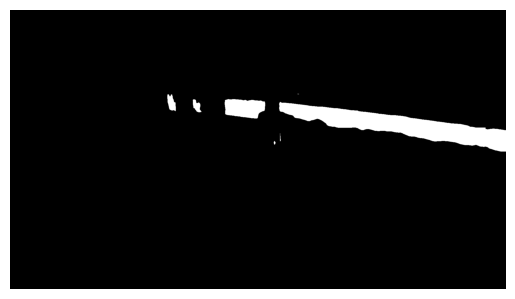

In [7]:
input = img_1
image = cv2.cvtColor(input, cv2.COLOR_BGR2RGB)
predictor.set_image(image)

input_point = np.array([cor1])
# print(input_point)
input_label = np.array([1])

masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

img_1_mask = (masks[1] * 255).astype(np.uint8)  # 마스크를 0-255 범위로 변환
plt.imshow(img_1_mask, cmap='gray')
plt.axis('off')

(-0.5, 1919.5, 1079.5, -0.5)

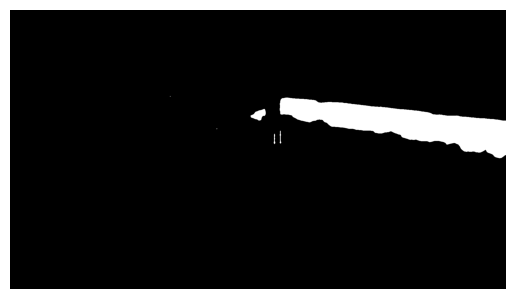

In [8]:
input = img_n
image = cv2.cvtColor(input, cv2.COLOR_BGR2RGB)
predictor.set_image(image)

input_point = np.array([cor2])
# print(input_point)
input_label = np.array([1])

masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

img_n_mask = (masks[2] * 255).astype(np.uint8)  # 마스크를 0-255 범위로 변환
plt.imshow(img_n_mask, cmap='gray')
plt.axis('off')

## ROI 1

In [9]:
'''
ROI 1: 기준점

변수 
distances: 사용자가 찍은 점들을 통해 얻은 도로폭들로 이루어진 1차원 배열
road_real_distance: 실제 도로폭 (현재 300cm)
h_mean_distance: distances 배열의 요소들의 조화평균
cal_har_result: 도로폭 환산비율. road_real_distance / h_mean_distance (실제 도로폭/사진 속 도로폭)
harmonic_height_mask: mask 를 통해 얻은 침수 비교 결과값
expecting_flood_height: 예상 침수값. harmonic_height_mask * cal_har_result

동작 과정
1. 입력된 두 개의 마스크 파일에서 침수 비교 영역을 찾고, 해당 영역에서 동일한 x값에 대한 y값의 높이 차를 구함. 
    y 값 변화량의 조화평균을 구함
2. 사용자가 도로폭에 대해 세 쌍의 점을 찍음 
   (점 한 개를 찍는 경우 빨간색으로 점을 표시, 한 쌍의 점을 찍으면 바로 전에 찍은 점과 연결하는 선을 그리며 길이를 보여줌)
3. 세 쌍의 도로폭의 조화평균을 구함
4. 마지막 이미지 프레임에 아래 계산 수행 및 결과 표시
    도로폭의 조화평균, 환산 비율 (실제 도로폭과 이미지 프레임의 도로폭을 비교하여 얻음), 예상 침수 높이
'''

img_1 = cv2.imread(f'test/{location}/{s}.jpg', cv2.IMREAD_COLOR) # 물 웅덩이 box 칠, 첫번째 이미지
img_n = cv2.imread(f'test/{location}/{f}.jpg', cv2.IMREAD_COLOR) # n번째 이미지, 해당 코드에서 n=5

points = []  # 점을 이을 때 저장할 배열
distances = []  # 직접 찍은 두 점의 L2 거리

# 사용자가 도로폭에 대해 세 쌍의 점을 찍는 함수
def draw_point(event, x, y, flags, param):
    global points, distances
    img_height, img_width = img_1.shape[:2]
    
    if event == cv2.EVENT_LBUTTONDOWN:
        points.append((x, y))
        cv2.circle(img_1, (x, y), 3, (0, 0, 255), -1)
        cv2.imshow('Blended Image', img_1)
        
        # 점이 적어도 두 개 이상일 때, 마지막으로 추가된 두 점의 거리를 계산하고 표시
        if len(points) % 2 == 0:
            pt1 = np.array(points[-2])
            pt2 = np.array(points[-1])
            
            distance = np.linalg.norm(pt2 - pt1)  
            distances.append(distance)
            
            # 점 쌍에 대한 번호 표시
            pair_num = len(distances)
            print(f"점 {2*pair_num - 1}과 점 {2*pair_num} 사이의 거리: {distance:.2f} px")
            
            # 거리를 이미지에 표시
            mid_x = (pt1[0] + pt2[0]) // 2
            mid_y = (pt1[1] + pt2[1]) // 2
            # 거리와 선을 img_1에 표시
            cv2.putText(img_1, f'{distance:.2f} px', (mid_x, mid_y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
            cv2.line(img_1, (pt1[0], pt1[1]), (pt2[0], pt2[1]), (0, 0, 255), 2)

            cv2.imshow('Blended Image', img_1)
            
            if len(distances) % 3 == 0:  # 세 쌍의 점이 찍힌 경우
                # 도로 폭의 조화평균 구하기 (h_mean_distance)
                h_mean_distance = hmean(distances)
                position = (min(1600, img_width - 500), min(850, img_height - 50))
                text = f"Average road width = {h_mean_distance:.2f} px"
                cv2.putText(img_n, text, position, cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)
                print(f"도로 폭의 평균(조화): {h_mean_distance:.2f} px")
                
                # 환산비율 구하기 (cal_har_result)
                cal_har_result = road_real_distance / h_mean_distance  # 조화 평균 계산 후 환산 비율 계산
                position2 = (min(1600, img_width - 500), min(880, img_height - 20))
                text2 = f"Ratio = {cal_har_result:.2f} cm/px"
                cv2.putText(img_n, text2, position2, cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
                print(f"환산 비율: {cal_har_result:.2f} cm/px")

                # 예상 침수 높이 계산 및 표시 (expecting_flood_height)
                expecting_flood_height = harmonic_height_mask * cal_har_result
                position3 = (min(1600, img_width - 500), min(910, img_height))
                text3 = f"Expecting Flood Height = {expecting_flood_height:.2f} cm"
                cv2.putText(img_n, text3, position3, cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
                print(f"예상 침수 깊이: {expecting_flood_height:.2f} cm/px")

                cv2.imshow('Blended Image', img_n)  # 조화평균을 표시한 이미지를 업데이트하여 보여줌
                cv2.waitKey(0)  # 0.5초 대기 후 창 닫기
                cv2.destroyAllWindows()

# 이미지 경로 확인 및 로드
img_1_array = np.array(img_1_mask)
img_n_array = np.array(img_n_mask)

mask_height, mask_width, = img_1_array.shape
height = []
x_array = []

# 침수 비교 영역 설정
for x in range(mask_width):
    for y in range(mask_height):
        if img_n_array[y, x] > 200:  # 침수 후 영역의 x 값이
            if img_1_array[y, x] > 200:  # 침수 전 영역의 x 값에도 있다면
                x_array.append(x)  # 올바른 침수 비교 영역으로 설정
                break

print(f"Valid X coordinates count: {len(x_array)}")

# y 값의 증가 값 계산
for x in x_array:
    for y in range(mask_height):
        if img_1_array[y, x] > 200:
            a = y  # 침수 비교 영역의 x값에 대한 가장 높은 침수 전 영역의 y 값
            break
    for y in range(mask_height):
        if img_n_array[y, x] > 200:
            b = y  # 침수 비교 영역의 x값에 대한 가장 높은 침수 후 영역의 y 값
            break
    height.append(a - b)  # y 값의 증가 값

height = np.array(height)

# 조화 평균 계산
if len(height) > 0 and np.sum(height > 0) > 0:  # 0으로 나누는 경우 방지
    harmonic_height_mask = len(height) / np.sum(1.0 / height[height > 0])
    print(f"Mask's Harmonic Flood Height: {harmonic_height_mask}")
else:
    harmonic_height_mask = 0
    print("No valid height data for harmonic mean calculation.")

# 이미지 처리
alpha = 0.2
img_rev = 255 - img_n_array  # 이미지 반전
img_col = cv2.cvtColor(img_rev, cv2.COLOR_GRAY2BGR)  # 색상 변환

# 마스크 생성 및 적용
lower_black = np.array([0, 0, 0])
upper_black = np.array([50, 50, 50])
mask = cv2.inRange(img_col, lower_black, upper_black)
img_col[mask != 0] = [128, 0, 128]  # 특정 색상으로 변경

# 이미지 블렌딩
img_1_bgr = cv2.cvtColor(np.array(img_1_mask), cv2.COLOR_GRAY2BGR)  # img_1도 BGR로 변환
combined_img = cv2.addWeighted(img_1_bgr, 0.7, img_col, 0.4, 0)

cv2.imwrite(f"test_pics/result/{location}/result.jpg", combined_img)

# 결과 표시
cv2.imshow('Blended Image', img_1)
cv2.setMouseCallback('Blended Image', draw_point)
cv2.waitKey(0)


Valid X coordinates count: 941
Mask's Harmonic Flood Height: 25.701116101018158
점 1과 점 2 사이의 거리: 201.76 px
점 3과 점 4 사이의 거리: 180.61 px
점 5과 점 6 사이의 거리: 208.15 px
도로 폭의 평균(조화): 196.11 px
환산 비율: 1.53 cm/px
예상 침수 깊이: 39.32 cm/px


-1

## ROI 2

In [10]:
'''
ROI_2: 물 웅덩이

변수
water_start_x, water_start_y: 사용자가 드래그를 시작한 점의 좌표
water_final_x, water_final_y: 사용자가 드래그를 끝낸 점의 좌표
water_width, water_height: 물 웅덩이 박스의 넓이와 높이 (water_start 와 water_final 의 절댓값을 이용해서 구함)

동작 과정
1. 이미지 로드 후 image 윈도우 생성 및 draw_rectangle 함수 호출
2. 사용자가 드래그하며 사각형 그림 -> 정보 계산 (water_start, water_final, water_width, water_height)
3. 첫번째 이미지 프레임 복사 후, 복사한 첫번째 이미지에 사각형 표시. 마지막 이미지에도 사각형 표시
4. 사각형의 좌표 출력
5. 1~4 과정을 사용자가 image 윈도우 종료할 때까지 반복
6. 사용자가 image 윈도우 종료하면 마지막 이미지 프레임 (img_n) 보여줌
'''

drawing = False  # 드래그 상태를 확인하는 플래그

img_1 = cv2.imread(f'test/{location}/{s}.jpg', cv2.IMREAD_COLOR) # 물 웅덩이 box 칠, 첫번째 이미지
img_n = cv2.imread(f'test/{location}/{f}.jpg', cv2.IMREAD_COLOR) # n번째 이미지, 해당 코드에서 n=5

cor = []

# 마우스 콜백 함수
def draw_rectangle(event, x, y, flags, param):
    global drawing, water_start_x, water_start_y, water_width, water_height, water_final_x, water_final_y 

    # 마우스 왼쪽 버튼을 누른 경우
    if event == cv2.EVENT_LBUTTONDOWN:
        drawing = True
        water_start_x = x
        water_start_y = y

    # 마우스를 움직이는 중이고, 드래그 상태인 경우
    elif event == cv2.EVENT_MOUSEMOVE:
        if drawing:
            img_1_copy = img_1.copy()
            cv2.rectangle(img_1_copy, (water_start_x, water_start_y), (x, y), (0, 255, 0), 2)
            cv2.imshow('image', img_1_copy)

    # 마우스 왼쪽 버튼을 뗀 경우
    elif event == cv2.EVENT_LBUTTONUP:
        drawing = False
        water_final_x = min(water_start_x, x)
        water_final_y = min(water_start_y, y)
        water_width = abs(water_start_x - x)
        water_height = abs(water_start_y - y)

        # 투명한 레이어 생성
        overlay = img_1.copy()

        # 반투명한 분홍색 마스크 칠하기
        cv2.rectangle(overlay, (water_final_x, water_final_y), 
                      (water_final_x + water_width, water_final_y + water_height), 
                      (147, 20, 255), -1)  # 분홍색으로 채우기

        # 알파 블렌딩을 통해 반투명 적용
        alpha = 0.5  # 투명도 설정 (0: 완전 투명, 1: 완전 불투명)
        cv2.addWeighted(overlay, alpha, img_1, 1 - alpha, 0, img_1)
        cv2.imshow('image', img_1)

        # img_n에 동일한 반투명 분홍색 사각형 적용
        overlay_n = img_n.copy()
        cv2.rectangle(overlay_n, (water_final_x, water_final_y), 
                      (water_final_x + water_width, water_final_y + water_height), 
                      (147, 20, 255), 2)  # 분홍색으로 채우기
        cv2.addWeighted(overlay_n, alpha, img_n, 1 - alpha, 0, img_n)

        # 네 꼭짓점 좌표 계산
        top_left = (water_final_x, water_final_y)
        top_right = (water_final_x + water_width, water_final_y)
        bottom_left = (water_final_x, water_final_y + water_height)
        bottom_right = (water_final_x + water_width, water_final_y + water_height)

        # 네 꼭짓점 좌표 출력
        cor.append(top_left)
        cor.append(top_right)
        cor.append(bottom_left)
        cor.append(bottom_right)
        print(f"Top-left: {top_left}")
        print(f"Top-right: {top_right}")
        print(f"Bottom-left: {bottom_left}")
        print(f"Bottom-right: {bottom_right}")
        print("")

# cor_woong=[]
# def click_event2(event, x, y, flags, param):
#     if event == cv2.EVENT_LBUTTONDOWN:
#         print(f"Clicked at x={x}, y={y}")
#         cv2.putText(img_n, f'({x},{y})', (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
#         cv2.imshow('image', img_n)
#         cor_woong.append(x)
#         cor_woong.append(y)

# 이미지가 올바르게 로드되었는지 확인
if img_1 is None or img_n is None:
    print("Error: One or both images not found or unable to load.")
else:
    # 윈도우 생성 및 마우스 콜백 함수 설정
    cv2.namedWindow('image')
    cv2.setMouseCallback('image', draw_rectangle)

    # 이미지 표시
    cv2.imshow('image', img_1)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    # 결과 확인을 위해 img_n 표시
    # cv2.imshow('Result on img_n', img_n)
    # cv2.setMouseCallback('image', click_event2)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()
    # print(cor_woong)




    cor3 = []
def click_event3(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:
        print(f"Clicked at x={x}, y={y}")
        # cv2.putText(img_n, f'({x},{y})', (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
        cv2.imshow('image', img_n)
        cor3.append(x)
        cor3.append(y)



cv2.imshow('image', img_n)

cv2.setMouseCallback('image', click_event3)
cv2.waitKey(0)
cv2.destroyAllWindows()
print(cor3)

img_nn = cv2.imread(f'test/{location}/{f}.jpg', cv2.IMREAD_COLOR) # n번째 이미지, 해당 코드에서 n=5
input = img_nn
image = cv2.cvtColor(input, cv2.COLOR_BGR2RGB)
predictor.set_image(image)

input_point = np.array([cor3])
# print(input_point)
input_label = np.array([1])

masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

img_n_mask = (masks[1] * 255).astype(np.uint8)  # 마스크를 0-255 범위로 변환

roi = img_n_mask[cor[0][1]:cor[2][1], cor[0][0]:cor[1][0]]
roi_ori = image[cor[0][1]:cor[2][1], cor[0][0]:cor[1][0]]

percentage = (np.sum(roi)/255)/((cor[0][0]-cor[1][0])*(cor[0][1]-cor[2][1]))
if percentage > 0.5:
    print('level: 2')
elif percentage > 0:
    print('level: 1')
else:
    print('level: 0')

Top-left: (155, 447)
Top-right: (355, 447)
Bottom-left: (155, 638)
Bottom-right: (355, 638)

Clicked at x=235, y=566
[235, 566]
level: 2


In [11]:
roi_ori_BGR = cv2.cvtColor(roi_ori, cv2.COLOR_RGB2BGR)

cv2.imshow("image", roi_ori_BGR)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [15]:
alpha = 0.2
img_rev = 255-roi
img_col = cv2.cvtColor(img_rev, cv2.COLOR_GRAY2BGR)
# 검정색 범위 정의
lower_black = np.array([0, 0, 0])
upper_black = np.array([50, 50, 50])

# 검정색 픽셀 마스크 만들기
mask = cv2.inRange(img_col, lower_black, upper_black)

# 마스크를 사용하여 검정색 픽셀을 핑크색으로 변경
img_col[mask != 0] = [128, 0, 128]  # 핑크색 (BGR 형식)

combined_img = roi_ori*0.85 + img_col*0.3
# combined_img = cv2.addWeighted(combined_img, (1-alpha), img_col, alpha, 0)

# act_height = harmonic_height*cal_har_result

# position = (200,850)
# text = f"Mean Height = {harmonic_height:.4f}(pxls)"
# font = cv2.FONT_HERSHEY_SIMPLEX
# font_scale = 1
# color = (0, 0, 255)
# thickness = 2

# position2 = (200,900)
# text2 = f"Ratio = {cal_har_result:.4f}(m/pxls)"
# font = cv2.FONT_HERSHEY_SIMPLEX
# font_scale = 1
# color = (0, 0, 255)
# thickness = 2


# 텍스트 추가
# combined_img = cv2.putText(combined_img, text, position, font, font_scale, color, thickness)
# combined_img = cv2.putText(combined_img, text2, position2, font, font_scale, color, thickness)
# combined_img = cv2.putText(combined_img, text3, position3, font, font_scale, color, thickness)

cv2.imshow('image', combined_img)
cv2.waitKey(0)
cv2.destroyAllWindows()

## ROI 3

In [ ]:
'''
ROI 3: YOLO로 자동차 탐지 후 바운딩박스 생성

변수
unique_boxes: 바운딩 박스 좌표를 중복 저장하지 않기 위해 사용하는 set
class_id: 자동차의 class_id = 6
corners: YOLO 로 탐지한 bounding box의, 네 꼭짓점의 좌표

동작 과정
1. YOLO 로 첫번째 이미지 프레임에 있는 자동차 detect
2. 탐지 결과를 file_path 와 result_image_path 에 저장
3. 탐지 결과를 읽어들인 후, 조건에 맞는 객체 (자동차이며 신뢰도가 0.4 이상) 의 네 꼭짓점의 좌표 출력
4. 탐지 결과 이미지 보여줌
'''

# YOLO detection 관련 경로 설정
print(os.getcwd())
command = [
    './Algorithm/flooding/Scripts/python.exe', './YOLOv6-main/tools/infer.py',
    '--weights', './YOLOv6-main/runs/1000epochs_exp31_best_ckpt.pt',
    '--source', f'./test/' + location + '/2.jpg',
    '--yaml', './yolo/dataset.yaml',
    '--device', '0',
    '--save-txt', 
    '--save-dir', f'./test_result/' + location + '/'
]

subprocess.run(command)
print("==============")

file_path = f'./test_result/{location}/labels/{s}.txt'
result_image_path = f'./test_result/{location}/{s}.jpg'
result = []

with open(file_path, 'r') as file:
    for line in file:
        elements = line.strip().split()
        int_elements = list(map(float, elements))
        result.append(int_elements)

# 중복된 바운딩 박스 좌표를 저장하지 않도록 set 사용
unique_boxes = set()

# 바운딩 박스의 좌표 계산 및 출력
img_height, img_width = img_1.shape[:2]
for line in result:
    class_id = line[0]
    confidence = line[5]
    if class_id == 6 and confidence >= 0.4:
        # YOLO 형식: class, x_center, y_center, width, height, confidence
        x_center, y_center, width, height = line[1:5]

        # 이미지 좌표계로 변환
        x_center *= img_width
        y_center *= img_height
        width *= img_width
        height *= img_height

        # 바운딩 박스 좌표 (x_min, y_min, x_max, y_max)
        x_min = int(x_center - width / 2)
        y_min = int(y_center - height / 2)
        x_max = int(x_center + width / 2)
        y_max = int(y_center + height / 2)

        # 네 꼭짓점 좌표
        corners = ((x_min, y_min), (x_max, y_min), (x_max, y_max), (x_min, y_max))

        # 중복되지 않은 바운딩 박스 좌표만 추가
        if corners not in unique_boxes:
            unique_boxes.add(corners)
            # 좌표 출력
            print(f"Car detected with bounding box corners: {corners}")

# 탐지된 결과를 보여주기
detected_img = cv2.imread(f'test_result/{location}/{s}.jpg', cv2.IMREAD_COLOR)
cv2.imshow('Detected Cars', detected_img)
cv2.waitKey(0)  # 키 입력을 기다림
cv2.destroyAllWindows()